In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz, lfilter

%matplotlib widget


In [41]:
s1 = pd.read_csv('set-a-text/a02.csv',skiprows=[0,1],names=['time','channel1','channel2','channel3','channel4'],)
QRSpostions = np.loadtxt('set-a-text/a02.fqrs.txt',dtype=int,)

In [11]:
QRSpostions

array([  307,   656,  1042,  1416,  1794,  2163,  2542,  2912,  3289,
        3667,  4043,  4409,  4785,  5170,  5544,  5906,  6281,  6670,
        7044,  7404,  7777,  8168,  8545,  8903,  9272,  9663, 10045,
       10402, 10767, 11158, 11544, 11901, 12261, 12653, 13042, 13398,
       13755, 14148, 14539, 14893, 15249, 15644, 16034, 16386, 16744,
       17140, 17528, 17880, 18241, 18636, 19021, 19375, 19739, 20133,
       20515, 20871, 21238, 21630, 22010, 22368, 22737, 23128, 23506,
       23865, 24236, 24626, 25003, 25362, 25735, 26125, 26499, 26860,
       27235, 27623, 27996, 28359, 28735, 29120, 29493, 29859, 30236,
       30617, 30991, 31360, 31736, 32115, 32490, 32861, 33235, 33612,
       33990, 34362, 34734, 35111, 35490, 35862, 36232, 36609, 36990,
       37362, 37730, 38107, 38490, 38862, 39228, 39606, 39990, 40361,
       40727, 41104, 41488, 41860, 42226, 42604, 42987, 43358, 43725,
       44104, 44486, 44855, 45224, 45606, 45984, 46351, 46725, 47107,
       47481, 47848,

In [12]:
s1.head()

time  channel1 channel2  channel3  channel4
0  0.000       7.4   23.400      -5.5      -5.0
1  0.001       7.6   20.900      -5.1      -5.1
2  0.002       7.8   18.000      -4.6      -5.6
3  0.003       7.8   14.800      -4.1      -5.8
4  0.004       7.8   11.300      -3.6      -5.3

In [96]:
QRSpostions.shape

(160,)

In [13]:
def clean_data(fecg_df:pd.DataFrame)->pd.DataFrame:
    """
    This function takes a dataframe of FECG and clean it by removing the NaN values and convert the values to numeric.
    """
    for i in fecg_df.columns:
        fecg_df[i] = pd.to_numeric(fecg_df[i], errors='coerce').fillna(0)
    return fecg_df

In [42]:
s1 = clean_data(s1)

In [7]:
def plot_filter_response(freq,freq_resp):
    """
    Plot the magnitude and phase response of the filter.
    """
    angles = np.unwrap(np.angle(freq_resp))  # Unwrapped phase
    # Magnitude response
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(freq, 20 * np.log10(abs(freq_resp)))
    plt.title('Magnitude Response of the High-Pass FIR Filter')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.xlim([0, 50])  # Match paper's x-axis
    plt.ylim([-40, 10])  # Match paper's y-axis
    plt.grid()

    # Phase response (unwrap to visualize better)
    plt.subplot(1, 2, 2)
    plt.plot(freq, angles, linewidth=1.5)
    plt.title('Phase Response of the High-Pass FIR Filter')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (degree)')
    plt.grid()
    plt.xlim([0, 50])
    plt.ylim([-600, 0])  # Limit the y-axis for better visualization
    plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, filtfilt, freqz

def wander_removal(signal, cutoff=3.0, fs=400, num_taps=1001, 
                   plot_filter_coefs=False, plot_filter_resp=False, plot_result=False):
    """
    Apply a high-pass filter to remove baseline wander from the ECG signal.

    :param signal: ECG signal (numpy array)
    :param cutoff: Cut-off frequency (Hz)
    :param fs: Sampling frequency (Hz)
    :param num_taps: Number of taps (filter length, must be odd for FIR filter)
    :param plot_filter_coefs: Plot the filter coefficients
    :param plot_filter_resp: Plot the frequency response of the filter
    :param plot_result: Plot the original and filtered signals

    :return: Filtered signal
    """
    signal = np.asarray(signal, dtype=np.float64)

    # Design the high-pass FIR filter
    filter_taps = firwin(num_taps, cutoff, fs=fs, pass_zero="highpass", window='hamming')

    # Plot the filter coefficients
    if plot_filter_coefs:
        plt.figure()
        plt.plot(filter_taps, '.-')
        plt.xlabel('Index')
        plt.ylabel('Amplitude')
        plt.title(f'High-Pass FIR Filter Coefficients ({num_taps} taps)')
        plt.grid()
        plt.show()

    # Compute frequency response
    freq, freq_resp = freqz(filter_taps, worN=1024, fs=fs)
    
    if plot_filter_resp:
        # Compute filter delay
        delay_samples = (num_taps - 1) / 2  # FIR filter delay
        delay_time = delay_samples / fs  # Convert to seconds
        print(f"Filter Delay: {delay_samples} samples ({delay_time:.4f} sec)")

        # Plot frequency response
        plot_filter_response(freq, freq_resp)

    # Apply zero-phase filtering to avoid phase distortion
    filtered_signal = filtfilt(filter_taps, 1.0, signal)
    

    if plot_result:
        time = np.arange(len(signal)) / fs
        
        plt.figure(figsize=(12, 4))
        plt.plot(time, signal, label="Original Signal")
        plt.plot(time, filtered_signal, label="Filtered Signal", linewidth=1.5)
        plt.title("Signal Before and After High-Pass Filtering")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()
        plt.show()

    return filtered_signal

Filter Delay: 500.0 samples (1.2500 sec)


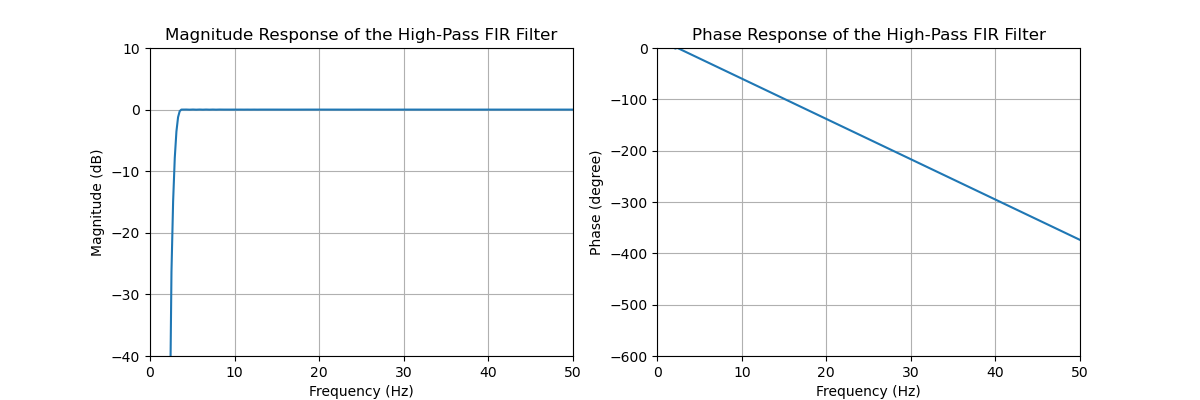

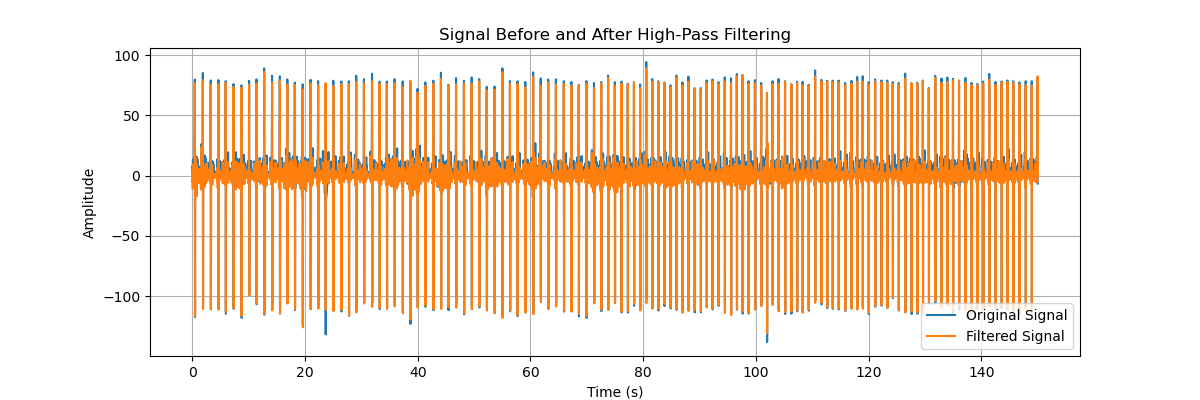

array([ 1.04480863e-09,  2.72311174e-01,  5.44710938e-01, ...,
        1.76522302e+01,  1.66750070e+01, -9.17739826e-10])

In [9]:
wander_removal(s1.channel1,plot_filter_resp=True,plot_result=True)

In [16]:
def baseline_wander_remover(fecg_df:pd.DataFrame)->pd.DataFrame:
    """
    This function takes a dataframe of FECG and apply a high-pass filter to remove the baseline wander.
    """
    for i in fecg_df.columns:
        if(i != 'time'):
            fecg_df[i] = wander_removal(fecg_df[i])
    return fecg_df

In [43]:
s2 = baseline_wander_remover(s1)

In [18]:
s2.head()

time      channel1      channel2      channel3      channel4
0  0.000  1.044809e-09  3.303861e-09 -7.765485e-10 -7.059531e-10
1  0.001  2.723112e-01 -1.271548e+00  4.482585e-01  2.276784e-01
2  0.002  5.447109e-01 -2.944212e+00  9.962832e-01  5.491205e-02
3  0.003  6.172875e-01 -4.919167e+00  1.543881e+00  1.811142e-01
4  0.004  6.901078e-01 -7.197665e+00  2.090840e+00  1.005628e+00

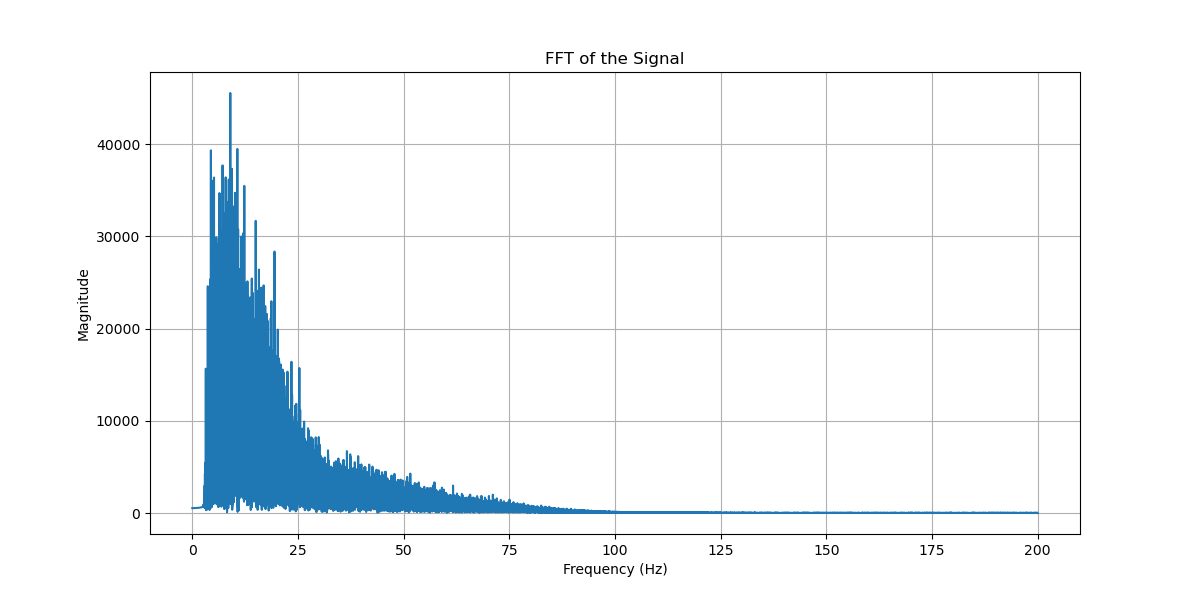

Frequency: 50.00 Hz, Magnitude: 2213.71
Frequency: 100.00 Hz, Magnitude: 97.83
Frequency: 150.00 Hz, Magnitude: 17.58
Frequency: 199.99 Hz, Magnitude: 4.21


In [44]:
# check for more than 50Hz noise

def check_noise(signal, fs=400, harmonics=[50, 100, 150, 200]):
    """
    Check for strong frequency components at 50 Hz or its harmonics in the signal.
    :param signal: Input signal
    :param fs: Sampling frequency (Hz)
    :param harmonics: List of harmonics to check (default is [50, 100, 150, 200])
    """
    # Perform FFT
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(signal), d=1/fs)  # Sampling frequency is fs

    # Plot the FFT result
    plt.figure(figsize=(12, 6))
    plt.plot(fft_freq[:len(fft_freq)//2], np.abs(fft_result)[:len(fft_result)//2])
    plt.title('FFT of the Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.show()

    # Check for strong frequency components at 50 Hz or its harmonics
    for harmonic in harmonics:
        idx = np.argmin(np.abs(fft_freq - harmonic))
        print(f"Frequency: {fft_freq[idx]:.2f} Hz, Magnitude: {np.abs(fft_result[idx]):.2f}")

# Example usage
check_noise(s2.channel1)


In [81]:
import numpy as np
from scipy.signal import butter, lfilter, iirfilter, welch


class AdaptiveCanceller:
    def __init__(self, fs, harmonics=1, cutoff_freq=80, adaptation_rate=0.01):
        """
        Initialize the adaptive canceller.

        :param fs: Sampling frequency (Hz)
        :param harmonics: Number of harmonics to cancel
        :param cutoff_freq: High-pass filter cutoff frequency (Hz)
        :param adaptation_rate: Step size for LMS adaptation
        """
        self.fs = fs
        self.harmonics = harmonics
        self.cutoff_freq = cutoff_freq
        self.adaptation_rate = adaptation_rate
        self.theta = np.zeros((harmonics, 3))  # Amplitude, frequency, phase for each harmonic
        self.error_filter = self._design_high_pass_filter()

    def _design_high_pass_filter(self):
        """Design a high-pass filter."""
        nyquist = 0.5 * self.fs
        cutoff = self.cutoff_freq / nyquist
        b, a = butter(2, cutoff, btype='high')
        return b, a

    def _apply_filter(self, signal):
        """Apply the high-pass filter to the signal."""
        b, a = self.error_filter
        return lfilter(b, a, signal)

    def _generate_interference(self, t):
        """Generate the interference estimate."""
        interference = np.zeros_like(t)
        self.theta[:, 1] = 50  # Initial frequency for each harmonic

        for n in range(self.harmonics):
            amplitude, freq, phase = self.theta[n]
            interference += amplitude * np.cos(2 * np.pi * freq * t + phase)
        return interference

    def adapt(self, corrupted_signal, t):
        """
        Perform LMS adaptation to cancel power line interference.

        :param corrupted_signal: Input signal containing interference
        :param t: Time vector corresponding to the signal
        :return: Cleaned signal
        """
        # Step 1: Generate the current interference estimate
        interference = self._generate_interference(t)


        # Step 2: Calculate the error signal (difference between corrupted signal and interference estimate)
        error_signal = corrupted_signal - interference

        # Step 3: Apply the high-pass filter to the error signal to focus on relevant frequency components
        filtered_error = self._apply_filter(error_signal)
        
        generated_interference = self._generate_interference(t)
        
        import matplotlib.pyplot as plt

        plt.plot(t, corrupted_signal, label="Corrupted Signal")
        plt.plot(t, generated_interference, label="Generated Interference")
        plt.legend()
        plt.show()

        # visualize the filtered error signal
        plt.figure(figsize=(12, 4))
        plt.plot(t, error_signal)
        plt.title("Filtered Error Signal")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.show()
        

        # Step 4: Update the parameters (amplitude, frequency, and phase) for each harmonic
        for n in range(self.harmonics):
            amplitude, freq, phase = self.theta[n]



            # Update amplitude based on the correlation between the error signal and the cosine of the estimated phase
            amplitude += self.adaptation_rate * np.mean(filtered_error * np.cos(2 * np.pi * freq * t + phase))

            # Update phase by adjusting it to minimize the error signal's projection on the sine of the estimated phase
            phase += self.adaptation_rate * np.mean(filtered_error * -np.sin(2 * np.pi * freq * t + phase))

            # Update frequency (slower adaptation) using the time-weighted sine of the estimated phase
            freq += self.adaptation_rate * np.mean(filtered_error * -t * np.sin(2 * np.pi * freq * t + phase))

            # Save the updated parameters
            self.theta[n] = [amplitude, freq, phase]

            print(f"Harmonic {n}: Amplitude = {amplitude}, Frequency = {freq}, Phase = {phase}")



        # Step 5: Generate the new interference estimate and subtract it from the corrupted signal
        cleaned_signal = corrupted_signal - self._generate_interference(t)
        # Debugging: Visualize the residual interference
        residual = corrupted_signal - cleaned_signal
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 4))
        plt.plot(t, residual, label="Residual Signal")
        plt.legend()
        plt.title("Residual Signal After Interference Cancellation")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.show()

        return cleaned_signal
    
    def validate_cleaning(self, corrupted_signal, cleaned_signal, fs):
        """
        Validate cleaning by analyzing power spectral density.

        :param corrupted_signal: Original corrupted signal
        :param cleaned_signal: Signal after interference cancellation
        :param fs: Sampling frequency (Hz)
        """
        # Calculate PSD for corrupted and cleaned signals
        f_corrupted, psd_corrupted = welch(corrupted_signal, fs, nperseg=1024)
        f_cleaned, psd_cleaned = welch(cleaned_signal, fs, nperseg=1024)

        # Plot PSD comparison
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.semilogy(f_corrupted, psd_corrupted, label="Corrupted Signal PSD")
        plt.semilogy(f_cleaned, psd_cleaned, label="Cleaned Signal PSD")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power Spectral Density")
        plt.title("Power Spectral Density Comparison")
        plt.legend()
        plt.grid()
        plt.show()

        # Print comparison at 50 Hz and harmonics
        for harmonic in range(0, self.harmonics):  # Check up to the 3rd harmonic
            target_freq = 50 * harmonic
            idx_corrupted = np.argmin(np.abs(f_corrupted - target_freq))
            idx_cleaned = np.argmin(np.abs(f_cleaned - target_freq))
            print(
                f"Power at {target_freq} Hz: Corrupted = {psd_corrupted[idx_corrupted]:.2e}, "
                f"Cleaned = {psd_cleaned[idx_cleaned]:.2e}"
            )
            
    def validate_filtering(self, corrupted_signal, t):
        """
        Validate the filter by analyzing the filtered signal.

        :param corrupted_signal: The input corrupted signal
        :param t: Time vector
        """
        filtered_signal = self._apply_filter(corrupted_signal)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 4))
        plt.plot(t, filtered_signal, label="Filtered Signal")
        plt.legend()
        plt.title("Filtered Signal Visualization")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.grid()
        plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter,welch, iirfilter, butter, freqz


# Step 1: Initialization of Parameters

def initialize_parameters(num_harmonics,corrupted_signal):
    """
    Initializes the adaptive interference cancellation parameters.

    Parameters:
        num_harmonics (int): Number of harmonics to account for in the interference.

    Returns:
        dict: A dictionary containing initialized parameters.
    """
    parameters = {
        'amplitude_estimates': [0.0 for _ in range(num_harmonics)],  # \tilde{\theta}_{a,i}(0)
        'phase_estimates': [0.0 for _ in range(num_harmonics)],      # \tilde{\theta}_{\phi,i}(0)
        'frequency_deviation_estimates': [0.0 for _ in range(num_harmonics)],  # \tilde{\theta}_{d\omega,i}(0)
        # 'reconstructed_interference': np.zeros_like(corrupted_signal),   # \tilde{x}_i(0), initially empty
        'scaling_factors': [1.0 for _ in range(num_harmonics)],  # \alpha_i = 1 initially
    }
    return parameters

# Step 2: Input Signal
def generate_input_signal(ecg_signal, num_harmonics, fundamental_frequency, sampling_rate, duration):
    """
    Generates a corrupted signal composed of an ECG signal and power line interference with harmonics.

    Parameters:
        ecg_signal (list): The clean ECG signal.
        num_harmonics (int): Number of harmonics to include in the interference.
        fundamental_frequency (float): The fundamental frequency of the power line interference (e.g., 50 Hz).
        sampling_rate (int): The sampling rate of the signal (e.g., 400 Hz).
        duration (float): Duration of the signal in seconds.

    Returns:
        list: The corrupted signal (ECG + interference).
    """

    time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    interference = np.zeros_like(time)

    for i in range(1, num_harmonics + 1):
        amplitude = 0.1 * i  # Example amplitude scaling for harmonics
        phase = np.random.uniform(0, 2 * np.pi)  # Random initial phase for each harmonic
        interference += amplitude * np.sin(2 * np.pi * fundamental_frequency * i * time + phase)

    corrupted_signal = ecg_signal + interference
    return corrupted_signal, interference

# Step 3: Harmonic Decomposition
def decompose_harmonics(corrupted_signal, parameters, num_harmonics, fundamental_frequency, sampling_rate, time):
    """
    Decomposes the corrupted signal into individual harmonic components and computes the modified signature vectors.
    Parameters:
    corrupted_signal (list): The input corrupted signal (ECG + interference).
    parameters (dict): The initialized parameters from Step 1.
    num_harmonics (int): Number of harmonics to extract.
    fundamental_frequency (float): The fundamental frequency of the power line interference (e.g., 50 Hz).
    sampling_rate (int): The sampling rate of the signal (e.g., 400 Hz).
    time (list): The time vector corresponding to the signal.

    Returns:
        dict: A dictionary containing updated harmonic components and their modified signature vectors.
    """
    # time = np.linspace(0, len(corrupted_signal) / sampling_rate, len(corrupted_signal), endpoint=False)
    reconstructed_interference = []
    modified_signature_vectors = []

    for i in range(num_harmonics):
        amplitude = parameters['amplitude_estimates'][i] # Use initial amplitude 
        phase = parameters['phase_estimates'][i] # Use initial phase 

        # Compute harmonic component
        harmonic = amplitude * np.sin(2 * np.pi * fundamental_frequency * (i + 1) * time + phase)
        reconstructed_interference.append(harmonic)

        sin_component = np.sin(2 * np.pi * fundamental_frequency * (i + 1) * time + phase)
        cos_component = np.cos(2 * np.pi * fundamental_frequency * (i + 1) * time + phase)
        scaling_factor = 1 / amplitude if amplitude > 0 else 1
        modified_signature_vector = [sin_component, scaling_factor * cos_component]
        modified_signature_vectors.append(modified_signature_vector)

    return {
        'reconstructed_interference': reconstructed_interference,
        'modified_signature_vectors': modified_signature_vectors,
    }

# Step 4: Error Signal Computation and Filtering
def design_error_filter(sampling_rate):
    """
    Designs a second-order IIR high-pass filter with a cutoff frequency of 80 Hz and unit gain at 50 Hz.
    Parameters:
        sampling_rate (int): The sampling rate of the signal.

    Returns:
        tuple: Filter coefficients (b, a).
    """
    # Define the specifications
    # fs = 1000  # Sampling frequency in Hz
    fc = 80    # Cutoff frequency in Hz
    f_target = 50  # Frequency with unity gain in Hz

    # Normalize the frequencies
    omega_c = fc / (sampling_rate / 2)  # Normalized cutoff frequency

    # Design a first-order high-pass filter
    b, a = butter(1, omega_c, btype='high', analog=False)

    # Evaluate the frequency response
    frequencies, h = freqz(b, a, worN=1024, fs=sampling_rate)

    # Find the gain at the target frequency
    target_index = np.argmin(np.abs(frequencies - f_target))
    gain_at_target = np.abs(h[target_index])

    # Apply gain correction
    b_scaled = b / gain_at_target

    # Recalculate the frequency response with scaling
    frequencies_scaled, h_scaled = freqz(b_scaled, a, worN=1024, fs=sampling_rate)

    # Plot the original and scaled frequency responses
    # plt.figure(figsize=(10, 6))
    # plt.plot(frequencies_scaled, 20 * np.log10(np.abs(h_scaled)), label='High-Pass Filter')
    # plt.axvline(fc, color='r', linestyle='--', label='Cutoff Frequency (80 Hz)')
    # plt.axvline(f_target, color='g', linestyle='--', label='Target Frequency (50 Hz)')
    # plt.title('Frequency Response of First-Order IIR High-Pass Filter')
    # plt.xlabel('Frequency (Hz)')
    # plt.ylabel('Magnitude (dB)')
    # plt.grid()
    # plt.xlim([0, 100])
    # plt.ylim([-40, 10])
    # plt.legend()
    # plt.show()

    # Display the coefficients
    (b_scaled, a), gain_at_target
    return b_scaled, a

def compute_error_signal_and_filter(corrupted_signal,reconstructed_interference,modified_signature_vectors, sampling_rate):
    """
    Computes the error signal by subtracting reconstructed interference from the corrupted signal
    and applies error filtering using a high-pass filter and a comb filter.
    Parameters:
        corrupted_signal (list): The input corrupted signal (ECG + interference).
        reconstructed_interference (list): The reconstructed interference from harmonic decomposition.
        parameters (dict): The updated parameters after harmonic decomposition.
        modified_signature_vectors (list): The modified signature vectors for all harmonics.
        sampling_rate (int): The sampling rate of the signal.

    Returns:
        dict: A dictionary containing the raw and filtered error signals.
    """

    reconstructed_interference = np.sum(reconstructed_interference, axis=0)
    # Compute the error signal
    error_signal = corrupted_signal - reconstructed_interference
    # Design filters
    b_hp, a_hp = design_error_filter(sampling_rate)

    # Apply high-pass filter on the error signal
    filtered_error_signal = lfilter(b_hp, a_hp, error_signal)

    # Apply filter on the modified signature vectors
    filtered_modified_signature_vectors = []
    for i in range(len(modified_signature_vectors)):
        sin_component, cos_component = modified_signature_vectors[i]
        filtered_modified_signature_vectors.append([
            lfilter(b_hp, a_hp, sin_component),
            lfilter(b_hp, a_hp, cos_component)
        ])

    assert np.all(np.isfinite(filtered_error_signal)), "Filtered error signal contains NaN values!"

    return {
        'filtered_error_signal': filtered_error_signal,
        'filtered_modified_signature_vectors': filtered_modified_signature_vectors,
    }

# Step 5: Adaptive Parameter Updates
def update_parameters(parameters, modified_signature_vectors, filtered_error_signal, learning_rates):
    """
    Updates the adaptive parameters (amplitude, phase, and frequency deviation) based on the filtered error signal
    and the modified signature vectors. Implements adaptation blocking for large amplitude events.
    Parameters:
        parameters (dict): The current parameter estimates.
        modified_signature_vectors (list): The modified signature vectors for all harmonics.
        filtered_error_signal (list): The filtered error signal.
        learning_rates (dict): Learning rates for updating amplitude, phase, and frequency deviation.
    Returns:
        dict: The updated parameters.
    """

    num_harmonics = len(parameters['amplitude_estimates'])

    for i in range(num_harmonics):
        sin_component, cos_component = modified_signature_vectors[i]

        # Update amplitude
        parameters['amplitude_estimates'][i] += learning_rates['amplitude'] * np.dot(filtered_error_signal, sin_component)

        # Update phase
        parameters['phase_estimates'][i] += learning_rates['phase'] * np.dot(filtered_error_signal, cos_component)

        # Update frequency deviation
        parameters['frequency_deviation_estimates'][i] += learning_rates['frequency'] * np.dot(filtered_error_signal, sin_component)

    return parameters

# Step 6: Final Output and Visualization
def visualize_results(corrupted_signal, cleaned_signal, time):
    """
    Visualizes the original ECG signal, corrupted signal, and cleaned signal.

    Parameters:
        ecg_signal (list): The original clean ECG signal.
        corrupted_signal (list): The corrupted signal (ECG + interference).
        cleaned_signal (list): The interference-free ECG signal.
        time (list): The time vector corresponding to the signal.
    """
    plt.figure(figsize=(12, 8))

    # Plot corrupted signal
    plt.subplot(2, 1, 1)
    plt.plot(time, corrupted_signal, label="Corrupted Signal", color='red')
    plt.title("Corrupted Signal (ECG + Interference)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xticks(np.linspace(time.min(), time.max(), 10))  # Set 10 evenly spaced ticks


    # Plot cleaned ECG signal
    plt.subplot(2, 1, 2)
    plt.plot(time, cleaned_signal, label="Cleaned ECG Signal", color='green')
    plt.title("Cleaned ECG Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xticks(np.linspace(time.min(), time.max(), 10))  # Set 10 evenly spaced ticks


    plt.subplots_adjust(hspace=0.4)
    plt.show()

def validate_cleaning(corrupted_signal, cleaned_signal,harmonics, fs):
    """
    Validate cleaning by analyzing power spectral density.

    :param corrupted_signal: Original corrupted signal
    :param cleaned_signal: Signal after interference cancellation
    :param fs: Sampling frequency (Hz)
    """
    # Calculate PSD for corrupted and cleaned signals
    f_corrupted, psd_corrupted = welch(corrupted_signal, fs, nperseg=1024)
    f_cleaned, psd_cleaned = welch(cleaned_signal, fs, nperseg=1024)

    # Plot PSD comparison
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.semilogy(f_corrupted, psd_corrupted, label="Corrupted Signal PSD")
    plt.semilogy(f_cleaned, psd_cleaned, label="Cleaned Signal PSD")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.title("Power Spectral Density Comparison")
    plt.legend()
    plt.grid()
    plt.show()

    # Print comparison at 50 Hz and harmonics
    for harmonic in range(1,harmonics):  # Check up to the 3rd harmonic
        target_freq = 50 * harmonic
        idx_corrupted = np.argmin(np.abs(f_corrupted - target_freq))
        idx_cleaned = np.argmin(np.abs(f_cleaned - target_freq))
        print(
            f"Power at {target_freq} Hz: Corrupted = {psd_corrupted[idx_corrupted]:.2e}, "
            f"Cleaned = {psd_cleaned[idx_cleaned]:.2e}"
        )
    


In [48]:
import numpy as np
from scipy.signal import lfilter, iirnotch,iircomb

# Initialize parameters
f_s = 400  # Sampling frequency (Hz)
f_p = 50   # Fundamental frequency (Hz)
beta = 8   # Comb filter parameter
k_chi = f_s  # Sliding window size (1 second window)
block_duration_samples = int(0.05 * f_s)  # Blocking duration (20 samples for 0.05 seconds)
def custom_comb_filter(signal, target_freq, fs):
    """
    Applies a custom comb filter to the signal to suppress specific harmonics.

    Parameters:
        signal (array): Input signal to be filtered.
        target_freqs (int): target frequency to suppress
        fs (int): Sampling frequency.

    Returns:
        array: Filtered signal with specified harmonics suppressed.
    """
    filtered_signal = signal.copy()

    b,a = iircomb(target_freq,8,fs=fs)
    filtered_signal = lfilter(b, a, filtered_signal)
    frequencies, h = freqz(b, a, worN=1024, fs=400)
    # Plot the original and scaled frequency responses
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, 20 * np.log10(np.abs(h)), label='Comb Filter')
    plt.title('Frequency Response of Comb Filter')
    plt.axvline(50, color='g', linestyle='--', label='Target Frequency (50 Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid()
    # plt.xlim([0, 100])
    # plt.ylim([-40, 10])
    plt.legend()
    plt.show()
        
    
    return filtered_signal

# Define the comb filter H(z)
def comb_filter(signal, beta = 8):
    b = [1] + [0] * (beta - 1) + [-1]  # Coefficients for H(z) = 1 - z^(-beta)
    a = [1] # Denominator coefficients (no feedback)
    frequencies, h = freqz(b, a, worN=1024, fs=400)
    # Plot the original and scaled frequency responses
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, 20 * np.log10(np.abs(h)), label='Comb Filter')
    plt.title('Frequency Response of Comb Filter')
    plt.axvline(50, color='g', linestyle='--', label='Target Frequency (50 Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid()
    # plt.xlim([0, 100])
    # plt.ylim([-40, 10])
    plt.legend()
    plt.show()
    return lfilter(b, a, signal)

# Function to calculate sigma_dH over a sliding window
def compute_sigma_dH(d_H, k_chi):
    return np.sqrt(np.convolve(d_H**2, np.ones(k_chi) / k_chi, mode='valid'))

# Function to implement adaptation blocking
def adaptation_blocking(corrupted_signal):
    # Apply the comb filter to the corrupted signal
    d_H = custom_comb_filter(corrupted_signal, 50, f_s)

    # Compute sigma_dH using a sliding window
    sigma_dH = compute_sigma_dH(d_H, k_chi)

    # Define the threshold \chi
    chi = np.sqrt(2) * sigma_dH

    # Initialize flags for adaptation blocking
    block_start = 0
    is_blocked = False

    # Iterate over the signal
    for k in range(len(d_H)):
        # Check if d_H exceeds the threshold (and index is valid for chi)
        if k >= len(chi):
            break
        if np.abs(d_H[k]) > chi[k - len(chi)]:
            # Block adaptation for the specified duration
            block_start = k
            is_blocked = True

        # Check if the blocking duration has passed
        if is_blocked and k > block_start + block_duration_samples:
            is_blocked = False

        # Perform adaptation only if not blocked
        if not is_blocked:
            ## Perform update parameters
            pass  # Placeholder for update_parameters function
    return d_H, sigma_dH, chi



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, freqz

def multi_channel_PLIC(signal, powerline_freq=50, fs=400, harmonics=3, quality_factor=60, plot_response=False):
    """
    Apply multiple notch filters to remove power-line interference and its harmonics.

    :param signal: Input ECG signal (numpy array)
    :param powerline_freq: Power-line frequency (Hz) (default: 50 Hz)
    :param fs: Sampling frequency (Hz) (default: 400 Hz)
    :param harmonics: Number of harmonics to remove (e.g., 3 removes 50, 100, 150 Hz)
    :param quality_factor: Quality factor of the notch filters (default: 30)
    :param plot_response: If True, plots the frequency response of the filter
    :return: Filtered signal
    """
    
    filtered_signal = signal.copy()

    # Plot frequency response setup
    if plot_response:
        plt.figure(figsize=(10, 5))
    
    for i in range(1, harmonics + 1):
        notch_freq = powerline_freq * i  # Compute harmonic frequency
        w0 = notch_freq / (fs / 2)  # Normalize frequency
        b, a = iirnotch(w0, quality_factor)

        # Apply notch filter
        filtered_signal = filtfilt(b, a, filtered_signal)

        # Plot frequency response
        if plot_response:
            w, h = freqz(b, a, fs=fs)
            plt.plot(w, 20 * np.log10(abs(h)), label=f'Notch at {notch_freq} Hz')

    if plot_response:
        plt.axvline(powerline_freq, color='r', linestyle='--', label='Fundamental')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.title('Notch Filter Frequency Response')
        plt.legend()
        plt.grid()
        plt.show()

    return filtered_signal

def Multi_Power_line_interference_canceller(fecg_df:pd.DataFrame)->pd.DataFrame:
    """
    This function takes a dataframe of FECG and apply a notch filter to remove the power-line interference.
    """
    for i in fecg_df.columns:
        if(i != 'time'):
            fecg_df[i] = multi_channel_PLIC(fecg_df[i])
    return fecg_df

In [45]:
s3 = Multi_Power_line_interference_canceller(s2)

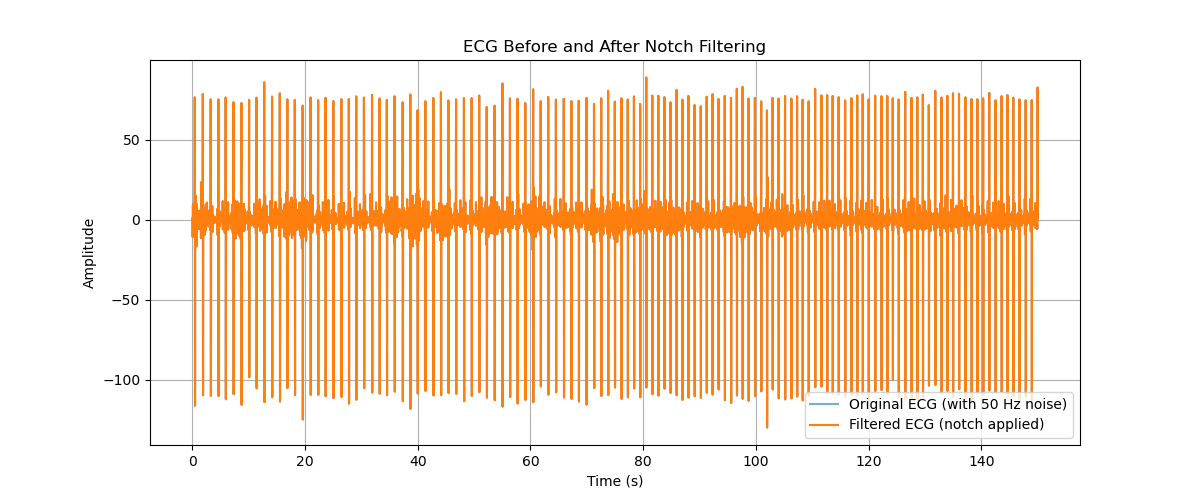

In [46]:
time = np.arange(len(s3.channel1)) / 400

# Plot original vs filtered ECG
plt.figure(figsize=(12, 5))
plt.plot(time, s2.channel1, label="Original ECG (with 50 Hz noise)", alpha=0.6)
plt.plot(time, s3.channel1, label="Filtered ECG (notch applied)", linewidth=1.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.title("ECG Before and After Notch Filtering")
plt.show()

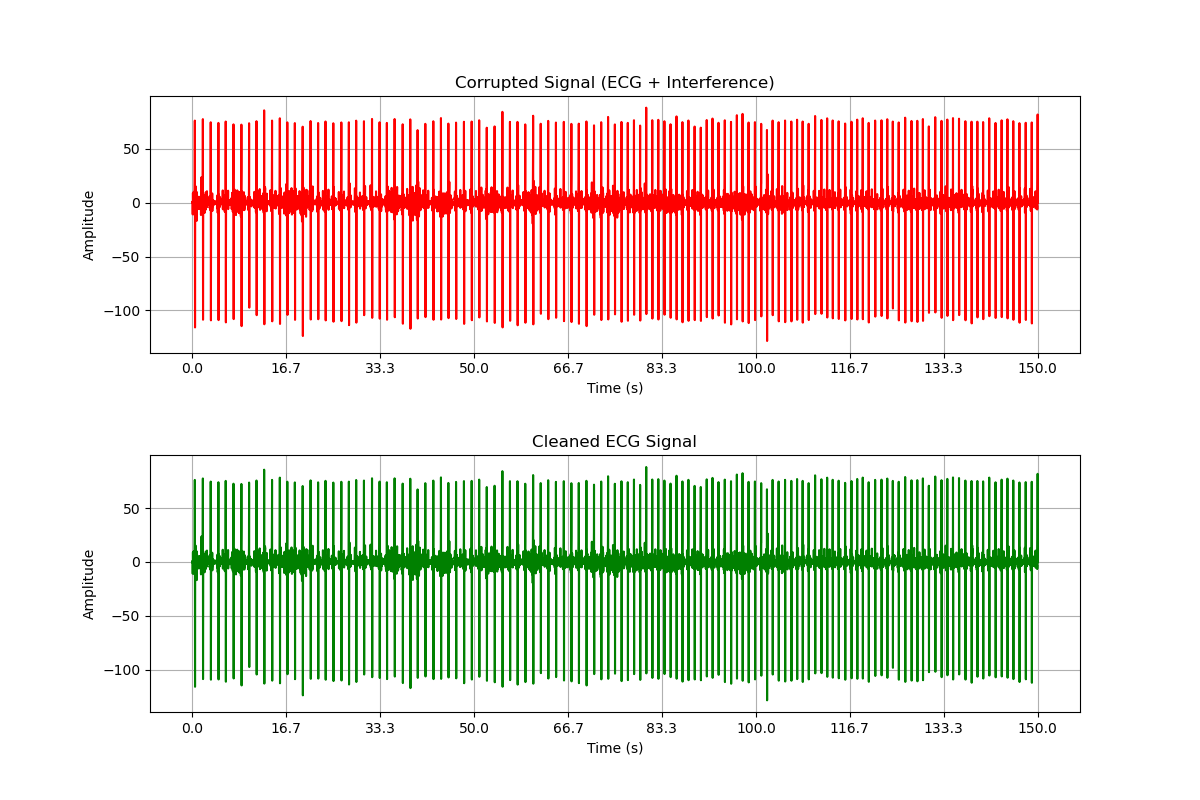

In [35]:
visualize_results(s2.channel1,s3.channel1,time)

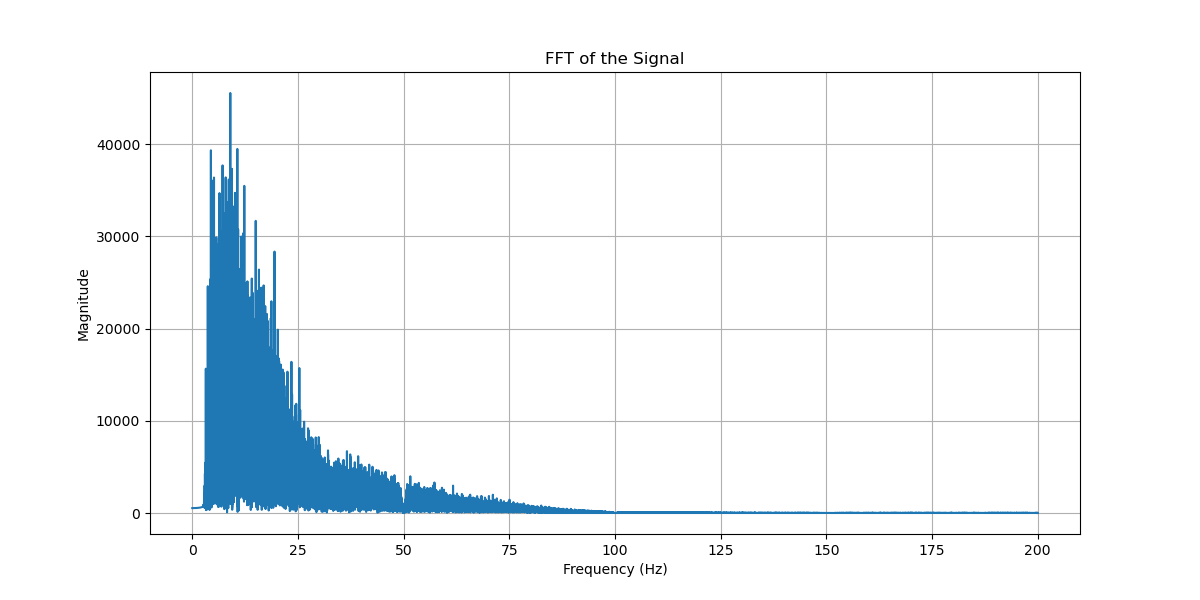

Frequency: 50.00 Hz, Magnitude: 58.38
Frequency: 100.00 Hz, Magnitude: 15.91
Frequency: 150.00 Hz, Magnitude: 7.11
Frequency: 199.99 Hz, Magnitude: 3.86


In [47]:
check_noise(s3.channel1)


/var/folders/vl/q0fkk3w14vs_kkjvpt2hg98h0000gn/T/ipykernel_72605/2845145075.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencies, 20 * np.log10(np.abs(h)), label='Comb Filter')


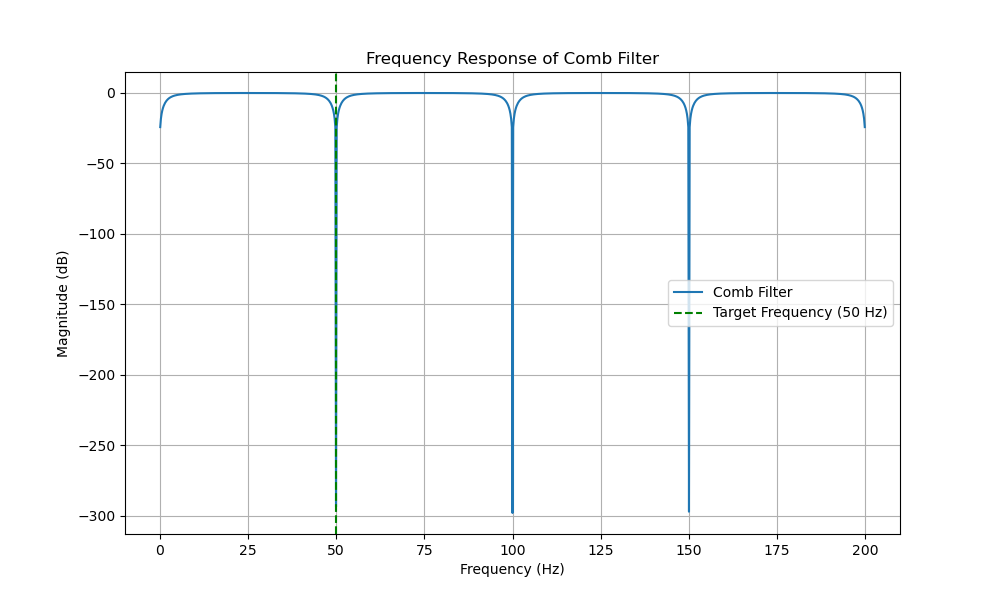

/var/folders/vl/q0fkk3w14vs_kkjvpt2hg98h0000gn/T/ipykernel_72605/5881524.py:264: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


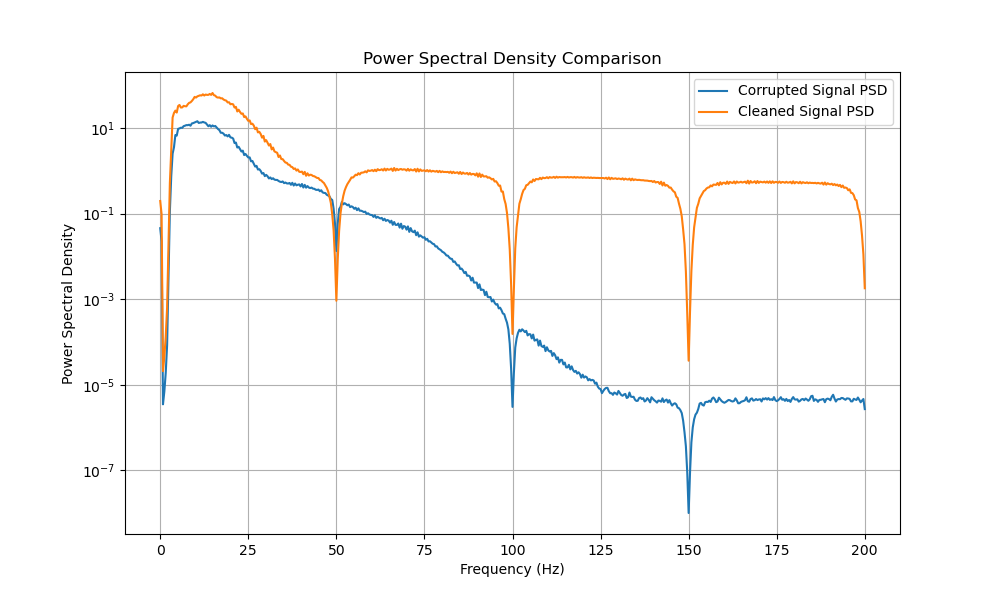

Power at 50 Hz: Corrupted = 1.33e-02, Cleaned = 9.17e-04
Power at 100 Hz: Corrupted = 3.04e-06, Cleaned = 1.54e-04


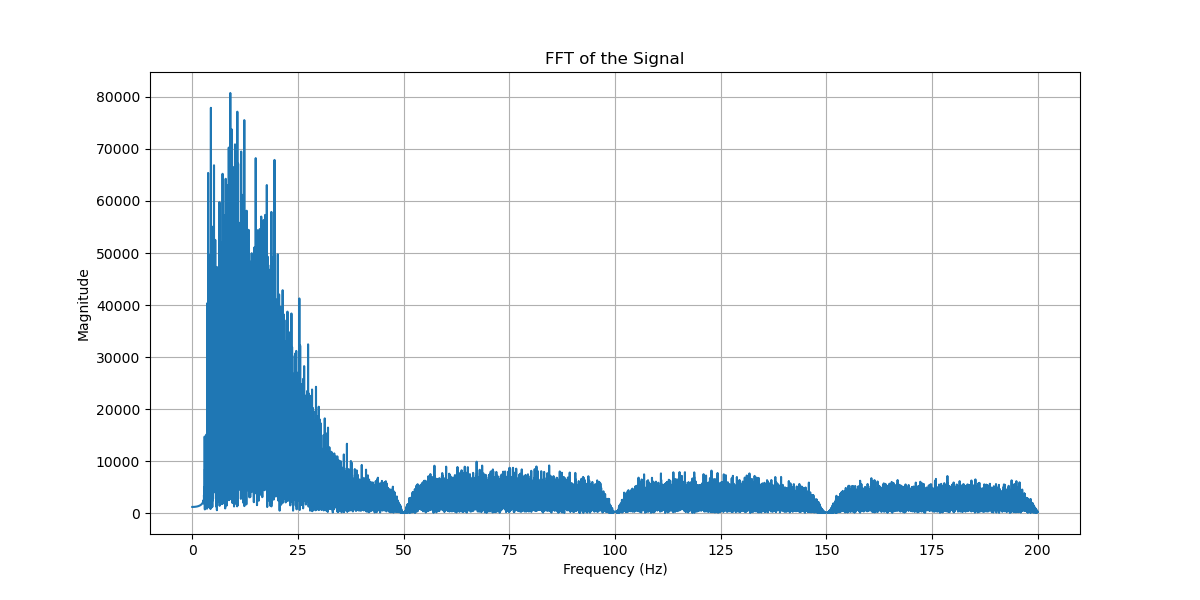

Frequency: 50.00 Hz, Magnitude: 72.77
Frequency: 100.00 Hz, Magnitude: 234.65
Frequency: 150.00 Hz, Magnitude: 118.78
Frequency: 199.99 Hz, Magnitude: 232.29


In [49]:

filtered_signal = custom_comb_filter(s2.channel2, 50, fs=400)

validate_cleaning(s2.channel1, filtered_signal, 3, 400)
check_noise(filtered_signal)


In [ ]:
visualize_results(s2.channel1, filtered_signal, time)

/var/folders/vl/q0fkk3w14vs_kkjvpt2hg98h0000gn/T/ipykernel_72605/2845145075.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencies, 20 * np.log10(np.abs(h)), label='Comb Filter')


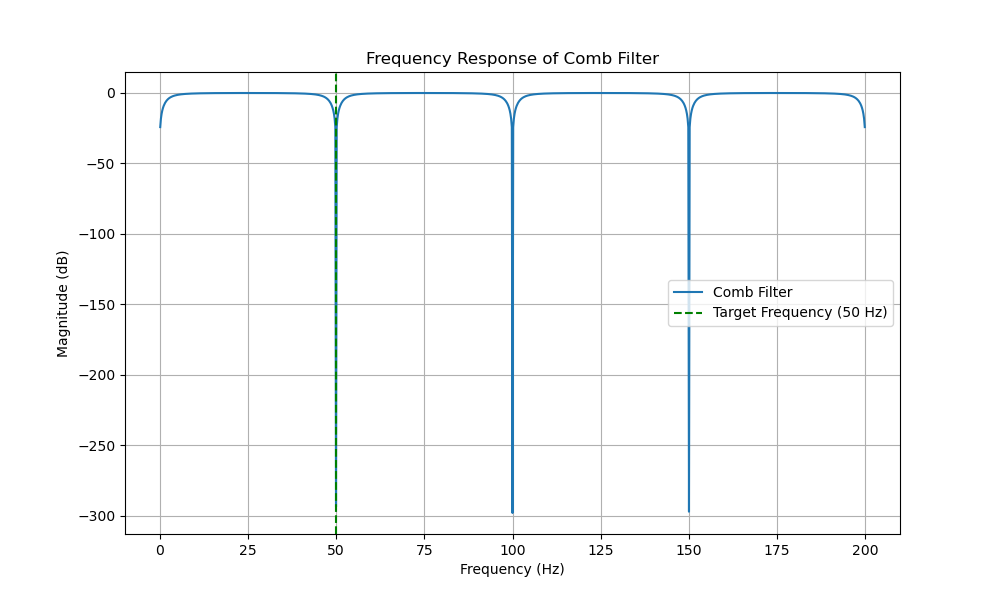

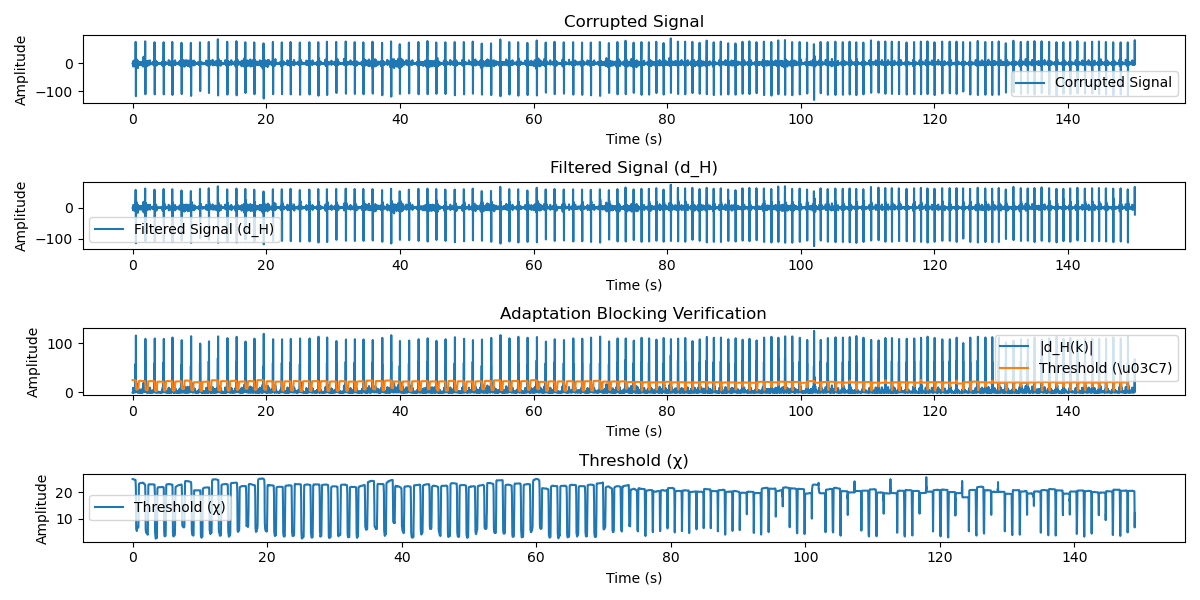

In [50]:
# Simulate a corrupted signal with a power-line interference component
t = time
corrupted_signal = s2.channel1

# Apply adaptation blocking
d_H, sigma_dH, chi = adaptation_blocking(corrupted_signal)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot the corrupted signal
plt.subplot(4, 1, 1)
plt.plot(t, corrupted_signal, label="Corrupted Signal")
plt.title("Corrupted Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Plot the filtered signal d_H
plt.subplot(4, 1, 2)
plt.plot(t[:len(d_H)], d_H, label="Filtered Signal (d_H)")
plt.title("Filtered Signal (d_H)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Plot the adapted signal 
plt.subplot(4, 1, 3)
plt.plot(t[:len(d_H)], np.abs(d_H), label="|d_H(k)|")
plt.plot(t[:len(chi)], chi, label="Threshold (\\u03C7)")
plt.title("Adaptation Blocking Verification")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Plot the threshold chi
plt.subplot(4, 1, 4)
plt.plot(t[:len(chi)], chi, label="Threshold (\u03C7)")
plt.title("Threshold (\u03C7)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

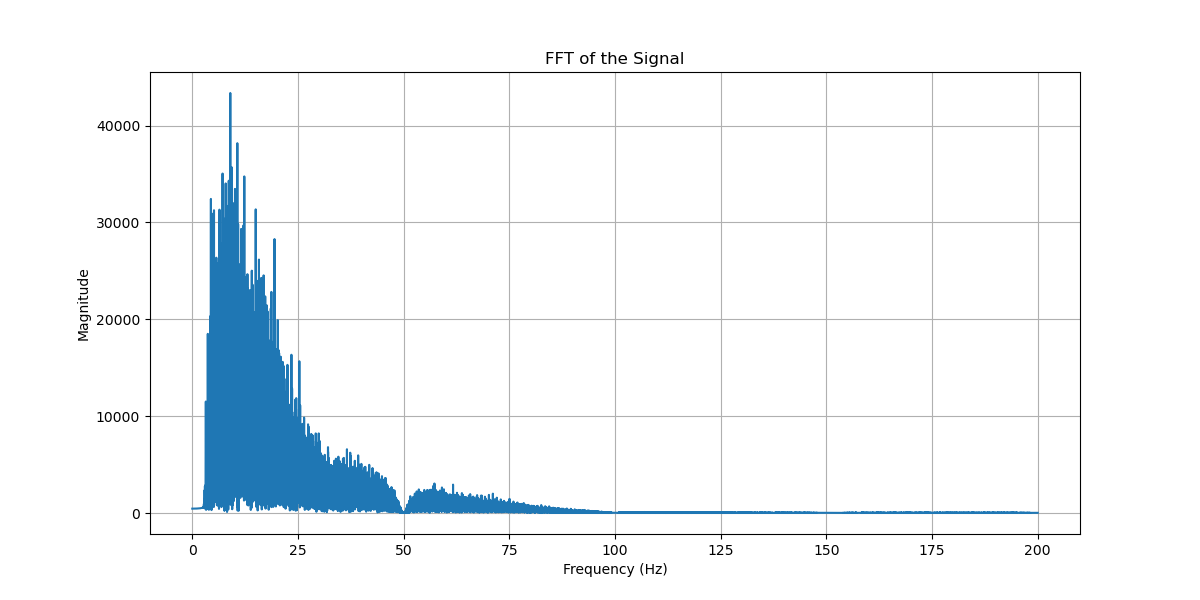

Frequency: 50.00 Hz, Magnitude: 39.73
Frequency: 100.00 Hz, Magnitude: 24.31
Frequency: 150.00 Hz, Magnitude: 18.87
Frequency: 199.99 Hz, Magnitude: 17.52


In [51]:
check_noise(d_H)

Time: [0.     0.0025 0.005  0.0075 0.01  ] [149.9875 149.99   149.9925 149.995  149.9975]
Cleaned Signal: [0.00044071 0.00052287 0.00054736 0.00054992 0.00054807] [ 0.75500119  0.77586303  0.89566591  0.79697657  0.6631697   0.52362714
  0.26682231 -0.00753622 -0.28423925 -0.79587873]


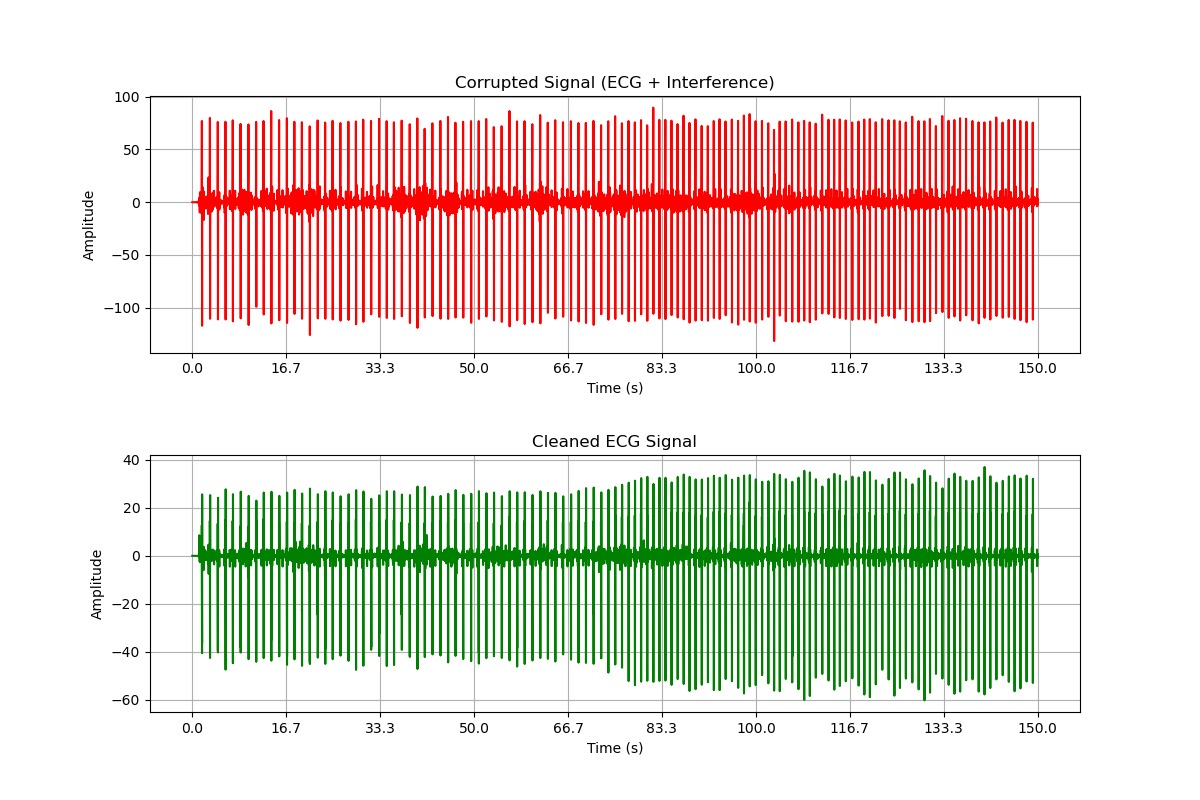

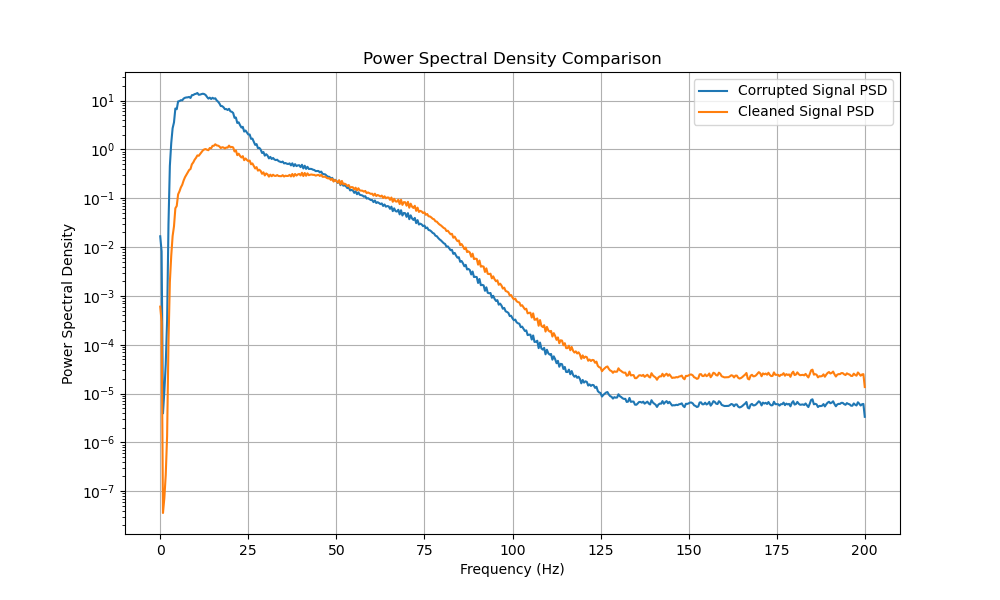

Power at 50 Hz: Corrupted = 2.26e-01, Cleaned = 2.26e-01
Power at 100 Hz: Corrupted = 3.47e-04, Cleaned = 9.25e-04


In [339]:
# Example of usage:

num_harmonics = 3  # Number of harmonics
corrupted_signal = s2.channel1
parameters = initialize_parameters(num_harmonics,corrupted_signal)
learning_rates = {
    'amplitude': 0.02,
    'phase': 0.0628,
    'frequency': 0.000986,
}

# Step 2: Generate input signal
sampling_rate = 400  # Hz
fundamental_frequency = 50  # Hz
duration = len(s2.channel1) / 400 # Calculate the duration of the signal
time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Step 3: Decompose harmonics
decomposition_results = decompose_harmonics(
    corrupted_signal, parameters, num_harmonics, fundamental_frequency, sampling_rate,time
)
modified_signature_vectors = decomposition_results['modified_signature_vectors']
reconstructed_interference = decomposition_results['reconstructed_interference']

# Step 4: Compute error signal
error_results = compute_error_signal_and_filter(
    corrupted_signal,reconstructed_interference,
    modified_signature_vectors,sampling_rate
)
filtered_error_signal = error_results['filtered_error_signal']
filtered_modified_signature_vectors = error_results['filtered_modified_signature_vectors']
#####--------------------------------------------------------------
# Apply adaptation blocking
d_H,_,_ = adaptation_blocking(filtered_error_signal)




#####------------------------------------------------


# Step 5: Update parameters

parameters = update_parameters(
    parameters, filtered_modified_signature_vectors, filtered_error_signal, learning_rates
)
# print(f"Expected length of time: {len(corrupted_signal)}")
# print(f"Actual length of time: {len(time)}")
# print(f"Time start: {time[0]}, Time end: {time[-1]}")

print("Time:", time[:5], time[-5:])
# print("Corrupted Signal:", corrupted_signal[:5], corrupted_signal[-5:])
print("Cleaned Signal:", filtered_error_signal[:5], filtered_error_signal[-10:])

# filtered_error_signal = np.nan_to_num(filtered_error_signal, nan=0.0)  # Replace NaN with 0

# Step 6: Visualize results
visualize_results(
    corrupted_signal=corrupted_signal,
    cleaned_signal=filtered_error_signal,
    time=time
)
validate_cleaning(corrupted_signal, filtered_error_signal,num_harmonics, sampling_rate)


/var/folders/vl/q0fkk3w14vs_kkjvpt2hg98h0000gn/T/ipykernel_87948/942338354.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencies, 20 * np.log10(np.abs(h)), label="High-Pass Filter")


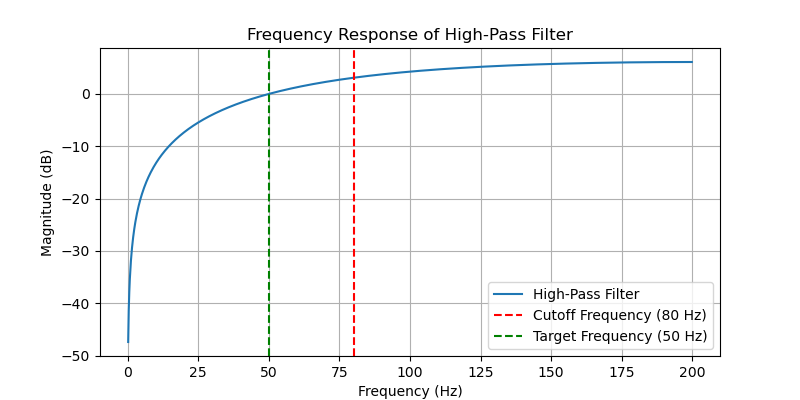

In [340]:
sampling_rate = 400  # Hz
b_hp, a_hp = design_error_filter(sampling_rate)

# Plot the frequency response of the filter
frequencies, h = freqz(b_hp, a_hp, worN=1024, fs=sampling_rate)
plt.figure(figsize=(8, 4))
plt.plot(frequencies, 20 * np.log10(np.abs(h)), label="High-Pass Filter")
plt.axvline(80, color='r', linestyle='--', label="Cutoff Frequency (80 Hz)")
plt.axvline(50, color='g', linestyle='--', label="Target Frequency (50 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Frequency Response of High-Pass Filter")
plt.legend()
plt.grid()
plt.show()

In [341]:
def workflow(corrupted_signal):
    """ Full workflow for adaptive interference cancellation."""
    learning_rates = {
    'amplitude': 0.0001,
    'phase': 0.00001,
    'frequency': 0.00001,
    }

    num_harmonics = 3  # Number of harmonics
    sampling_rate = 400  # Hz
    fundamental_frequency = 50  # Hz
    duration = len(corrupted_signal) / sampling_rate # Calculate the duration of the signal
    time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

    # Step 1: Initialization
    parameters = initialize_parameters(num_harmonics,corrupted_signal)

    # Step 2: Iterative Process
    for iteration in range(3):  # Example: Run for 100 iterations or until convergence
        # Harmonic Decomposition
        results = decompose_harmonics(corrupted_signal, parameters, num_harmonics, fundamental_frequency, sampling_rate, time)
        reconstructed_interference = results['reconstructed_interference']
        modified_signature_vectors = results['modified_signature_vectors']

        # Filter Error Signal
        filter_results = compute_error_signal_and_filter(corrupted_signal, reconstructed_interference, modified_signature_vectors, sampling_rate)
        filtered_error_signal = filter_results['filtered_error_signal']
        filtered_modified_signature_vectors = filter_results['filtered_modified_signature_vectors']

        assert np.all(np.isfinite(filtered_error_signal)), "Filtered error signal contains invalid values."
        assert np.all(np.isfinite(filtered_modified_signature_vectors)), "Filtered signature vectors contain invalid values."


        # Apply the comb filter 
        comb_filtered_error_signal = custom_comb_filter(filtered_error_signal,fundamental_frequency, sampling_rate)

        # Compute sigma_dH using a sliding window
        sigma_dH = compute_sigma_dH(comb_filtered_error_signal, k_chi)

        # Define the threshold 
        threshold = np.sqrt(2) * sigma_dH

        # Initialize flags for adaptation blocking
        block_start = 0
        is_blocked = False

        # Iterate over the signal
        for k in range(len(comb_filtered_error_signal)):
            # Check if comb_filtered_error_signal exceeds the threshold (and index is valid for chi)
            if k >= len(threshold):
                break
            if np.abs(comb_filtered_error_signal[k]) > threshold[k - len(threshold)]:
                # Block adaptation for the specified duration
                block_start = k
                is_blocked = True

            # Check if the blocking duration has passed
            if is_blocked and k > block_start + block_duration_samples:
                is_blocked = False

            # Perform adaptation only if not blocked
            if not is_blocked:
                ## Perform update parameters
                parameters = update_parameters(
                    parameters=parameters,
                    modified_signature_vectors=filtered_modified_signature_vectors,
                    filtered_error_signal=comb_filtered_error_signal,
                    learning_rates=learning_rates
                )
        if iteration % 2 == 0:
            print(f"Iteration {iteration}: Error = {np.mean(comb_filtered_error_signal**2)}")
            print(f"Iteration {iteration}: Amplitudes = {parameters['amplitude_estimates']}, "
                  f"Phases = {parameters['phase_estimates']}, Frequencies = {parameters['frequency_deviation_estimates']}")
        

    # Step 3: Final Output
    cleaned_signal = corrupted_signal - np.sum(reconstructed_interference, axis=0)
    visualize_results(corrupted_signal, np.sum(reconstructed_interference, axis=0), time)
    validate_cleaning(corrupted_signal, np.sum(reconstructed_interference, axis=0), num_harmonics, sampling_rate)

    return cleaned_signal

Iteration 0: Error = 25.288558432652778
Iteration 0: Amplitudes = [4.254588324606926, 5.1504408791861715, 4.480253295049459], Phases = [-0.825927018460875, -0.1512417732251269, 0.3479758334014921], Frequencies = [0.4254588324608303, 0.5150440879187649, 0.44802532950475743]
Iteration 2: Error = 335.286941667697
Iteration 2: Amplitudes = [9155.679921489984, 86485.42796176091, 148554.67463881292], Phases = [-14.629742609730187, -17.191863839089354, -22.812428741758747], Frequencies = [915.5679921486436, 8648.542796185959, 14855.467463912946]


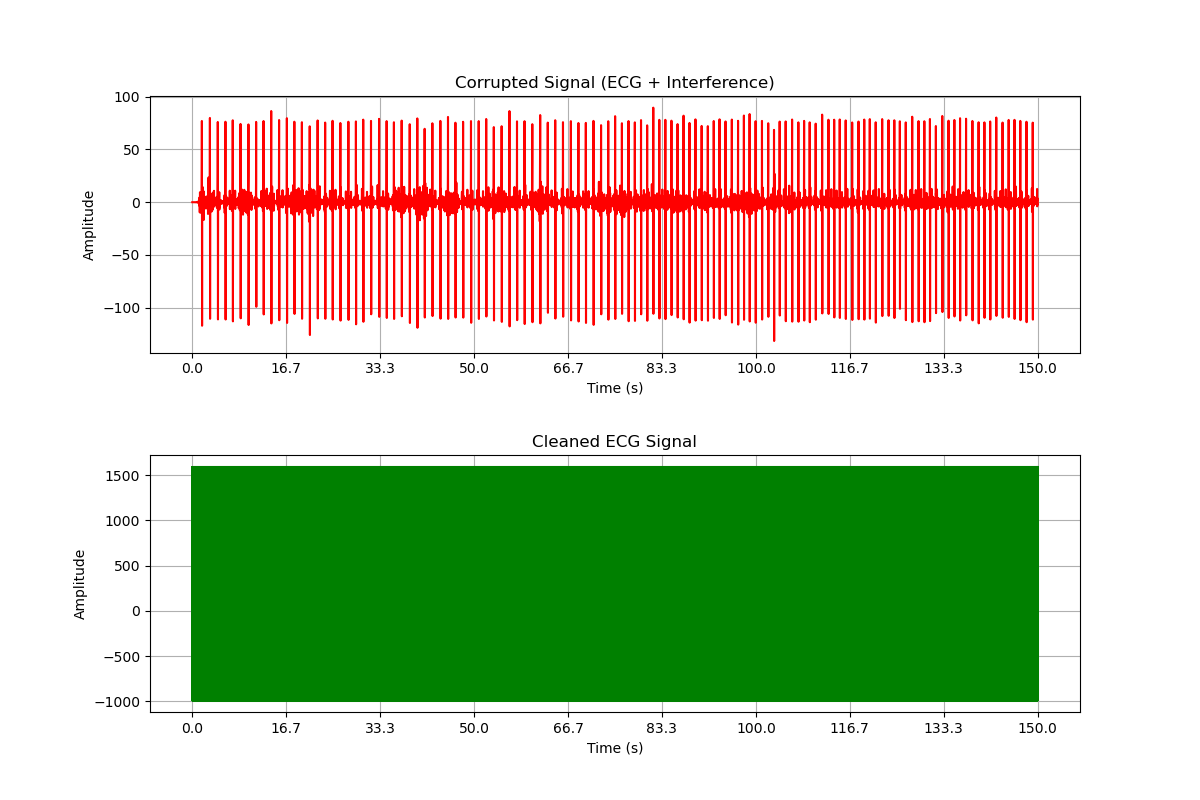

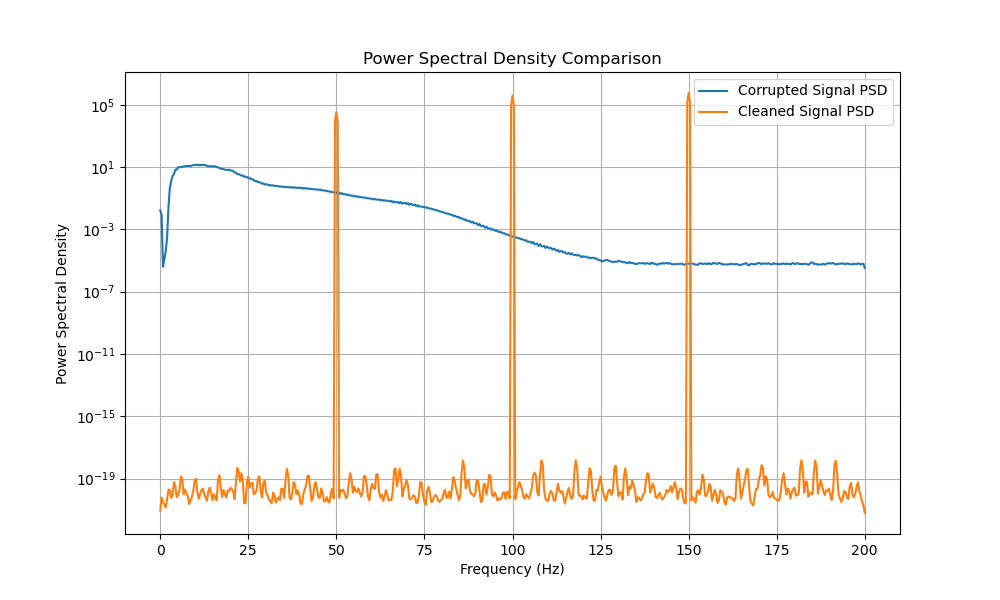

Power at 50 Hz: Corrupted = 2.26e-01, Cleaned = 3.47e+04
Power at 100 Hz: Corrupted = 3.47e-04, Cleaned = 3.82e+05


In [342]:
cleaned_signal = workflow(s2.channel1)

In [343]:
def workflow2(corrupted_signal):
    """ Full workflow for adaptive interference cancellation."""

    num_harmonics = 3  # Number of harmonics
    sampling_rate = 400  # Hz
    fundamental_frequency = 50  # Hz
    duration = len(corrupted_signal) / sampling_rate # Calculate the duration of the signal
    time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

    # Step 1: Initialization
    parameters = initialize_parameters(num_harmonics,corrupted_signal)

    # Step 2: Iterative Process
    # Harmonic Decomposition
    results = decompose_harmonics(corrupted_signal, parameters, num_harmonics, fundamental_frequency, sampling_rate, time)
    reconstructed_interference = results['reconstructed_interference']
    modified_signature_vectors = results['modified_signature_vectors']

    # Filter Error Signal
    filter_results = compute_error_signal_and_filter(corrupted_signal, reconstructed_interference, modified_signature_vectors, sampling_rate)
    filtered_error_signal = filter_results['filtered_error_signal']
    filtered_modified_signature_vectors = filter_results['filtered_modified_signature_vectors']

    assert np.all(np.isfinite(filtered_error_signal)), "Filtered error signal contains invalid values."
    assert np.all(np.isfinite(filtered_modified_signature_vectors)), "Filtered signature vectors contain invalid values."


    # Apply the comb filter 
    comb_filtered_error_signal = custom_comb_filter(filtered_error_signal, [50,100,150,200], fs=sampling_rate)
    comb_filtered_error_signal2 = comb_filter(filtered_error_signal)

    clean_data = corrupted_signal - comb_filtered_error_signal
    clean_data2 = corrupted_signal - comb_filtered_error_signal2
    # Step 3: Final Output
    visualize_results(corrupted_signal, clean_data, time)
    validate_cleaning(corrupted_signal, clean_data, num_harmonics, sampling_rate)
    visualize_results(corrupted_signal, clean_data2, time)
    validate_cleaning(corrupted_signal, clean_data2, num_harmonics, sampling_rate)


    return clean_data

In [344]:
workflow2(s2.channel1)

TypeError: float() argument must be a string or a real number, not 'list'

In [399]:
def powerline_interference_canceller(fecg_df:pd.DataFrame)->pd.DataFrame:
    """
    This function takes a dataframe of FECG and removes the powerline interference from the signal.
    """
    for i in fecg_df.columns:
        if i != 'time':
            fecg_df[i] = custom_comb_filter(fecg_df[i], 50, fs=400)
    return fecg_df

In [400]:
s3 = powerline_interference_canceller(s2)

In [401]:
s3.head()

time      channel1      channel2      channel3      channel4
0  0.000000e+00  6.799874e-13  2.150231e-12 -5.053961e-13 -4.594510e-13
1  4.247766e-08  2.740378e-12  8.377681e-12 -1.986352e-12 -1.848378e-12
2  1.274757e-07  6.898003e-12  2.033578e-11 -4.865476e-12 -4.681416e-12
3  2.549520e-07  1.386357e-11  3.936444e-11 -9.514851e-12 -9.487553e-12
4  4.247792e-07  2.433735e-11  6.645157e-11 -1.625334e-11 -1.674276e-11

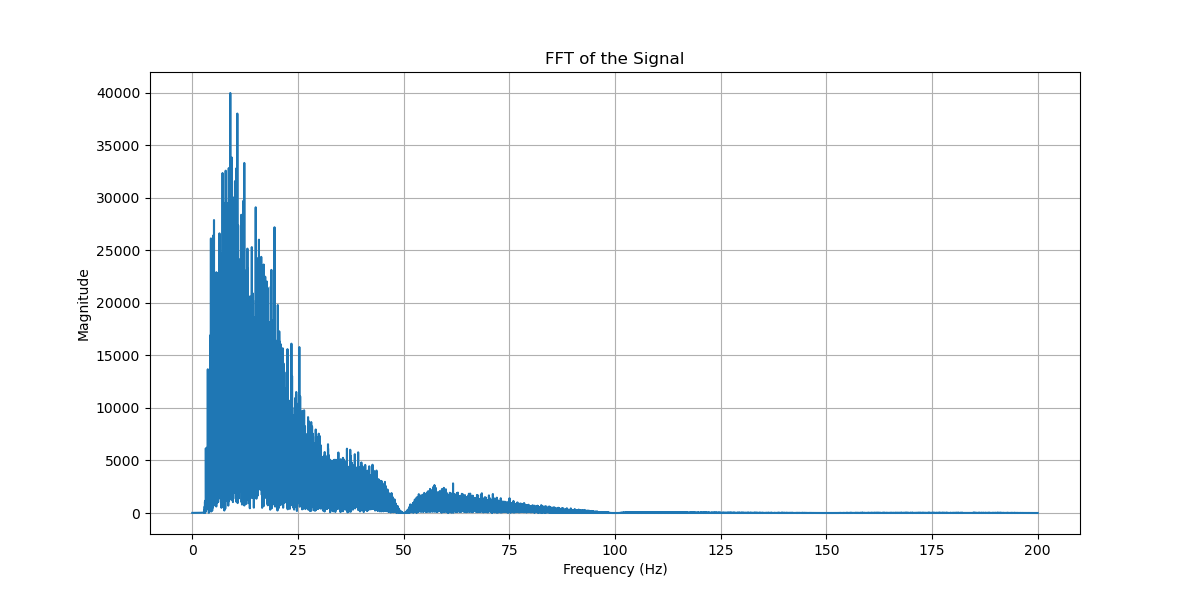

Frequency: 50.00 Hz, Magnitude: 0.98
Frequency: 100.00 Hz, Magnitude: 0.64
Frequency: 150.00 Hz, Magnitude: 0.52
Frequency: 199.99 Hz, Magnitude: 0.38


In [402]:
check_noise(s3.channel1)

In [ ]:
from scipy.signal import resample_poly

import pandas as pd
from scipy.signal import resample_poly

def upsampling(fecg_df: pd.DataFrame, fs: int, new_fs: int) -> pd.DataFrame:
    """
    Upsamples the signals in a dataframe from the original sampling frequency to a new sampling frequency.
    
    Args:
        fecg_df (pd.DataFrame): Input dataframe containing FECG signals. 
                                Assumes one column is 'time' and others are signal channels.
        fs (int): Original sampling frequency in Hz.
        new_fs (int): Target sampling frequency in Hz.
        
    Returns:
        pd.DataFrame: Upsampled dataframe with the time column adjusted.
    """
    # Calculate the upsampling factor
    upsample_factor = new_fs / fs
    
    # Initialize a new dictionary to store resampled data
    resampled_data = {}

        # Adjust the time column
    original_time = fecg_df['time'].values
    total_duration = original_time[-1]  # Total time duration in seconds
    new_sample_count = int(len(original_time) * upsample_factor)
    resampled_data['time'] = pd.Series(
        np.linspace(0, total_duration, new_sample_count)
    )
    
    # Upsample each signal column
    for col in fecg_df.columns:
        if col != 'time':
            # Resample the signal using polyphase resampling
            resampled_data[col] = resample_poly(fecg_df[col], up=int(upsample_factor), down=1)
    
 
    # Convert the dictionary to a dataframe
    resampled_df = pd.DataFrame(resampled_data)
    return resampled_df


In [412]:
s4 = upsampling(s3, sampling_rate, 2000)
sampling_rate = 2000  # Hz

In [413]:
s4.head()

time      channel1      channel2      channel3      channel4
0  0.000000e+00  6.799874e-13  2.150231e-12 -5.053961e-13 -4.594510e-13
1 -3.982511e-12  2.740378e-12  8.377681e-12 -1.986352e-12 -1.848378e-12
2 -7.965022e-12  6.898003e-12  2.033578e-11 -4.865476e-12 -4.681416e-12
3 -1.194753e-11  1.386357e-11  3.936444e-11 -9.514851e-12 -9.487553e-12
4 -1.593004e-11  2.433735e-11  6.645157e-11 -1.625334e-11 -1.674276e-11

In [414]:
from sklearn.decomposition import PCA

def multi_channel_QRS_enhancement(fecg_df:pd.DataFrame,show_plot=False)->pd.DataFrame:
    """
    This function takes a dataframe of FECG and enhances the QRS complex in the signal.
    """
    ecg_data = fecg_df.copy()  # 8 channels, 1000 samples (example)
    ecg_data.drop(columns=['time'], inplace=True)

    # Step 1: Normalize the variance of each channel
    normalized_data = (ecg_data - np.mean(ecg_data, axis=0)) / np.std(ecg_data, axis=0)

    # Step 2: Perform PCA on the normalized data
    pca = PCA(n_components=1)  # Extract only the first principal component
    principal_component = pca.fit_transform(normalized_data)

    # Step 3: Plot the first principal component
    if show_plot:
        plt.figure(figsize=(12, 6))
        # plt.plot(ecg_data, label="ECG Data (3 Channels)", alpha=0.2)
        plt.plot(principal_component, label="First Principal Component (PC1)")
        plt.title("First Principal Component of Multi-Channel ECG Data")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()
    return principal_component

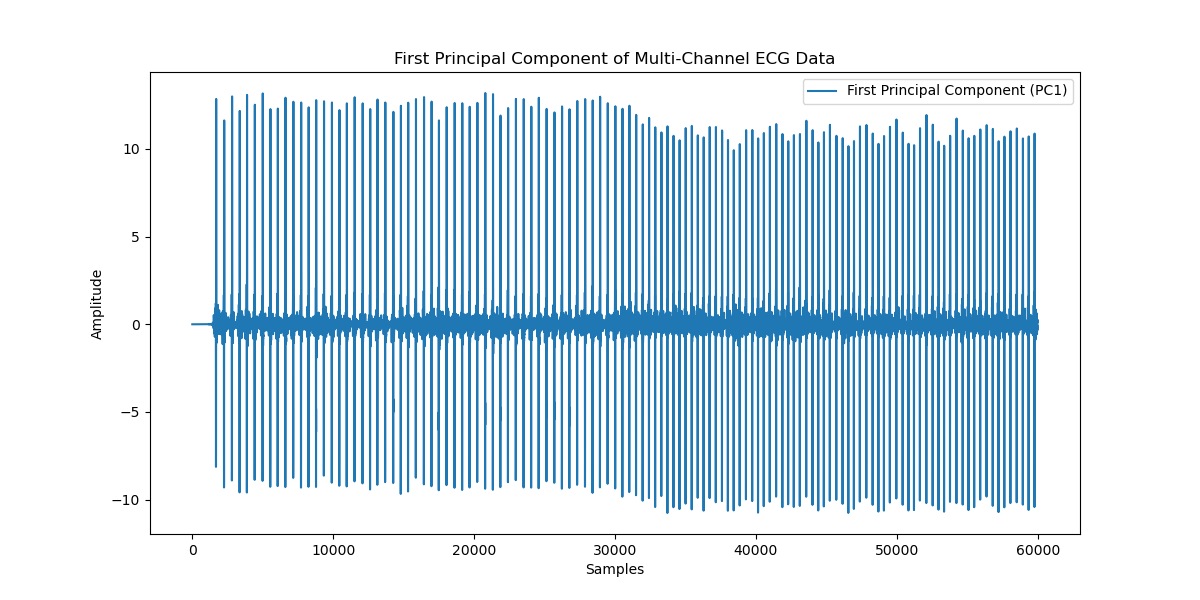

In [415]:
pca = multi_channel_QRS_enhancement(s3,show_plot=True)

In [432]:
def find_window_maxima(signal, fs):
    """
    Finds the sample with the maximum absolute amplitude in each 1-second window.
    
    Args:
        signal (np.array): Input signal.
        fs (int): Sampling frequency in Hz.
        
    Returns:
        List of indices of the maximum samples in each window.
    """
    window_size = fs  # 1 second window
    maxima_indices = []
    
    for i in range(0, len(signal), window_size):
        window = signal[i:i + window_size]
        max_idx = np.argmax(np.abs(window)) + i  # Find index of max absolute amplitude
        maxima_indices.append(max_idx)
    
    return maxima_indices

In [436]:
def extract_qrs_templates(signal, maxima_indices, fs):
    """
    Extracts QRS templates from the signal based on maxima indices.
    
    Args:
        signal (np.array): Input signal.
        maxima_indices (list): Indices of maxima in each window.
        fs (int): Sampling frequency in Hz.
        
    Returns:
        List of QRS templates (np.array) and their corresponding indices.
    """
    template_duration = 0.1  # 0.1 seconds
    template_samples = int(template_duration * fs)  # Number of samples in the template
    half_template = template_samples // 2

    templates = []
    template_indices = []

    for idx in maxima_indices:
        start = max(0, idx - half_template)  # Handle start boundary
        end = min(len(signal), idx + half_template)  # Handle end boundary
        template = signal[start:end]
        
        # Pad template if necessary (e.g., at edges)
        if len(template) < template_samples:
            template = np.pad(template, (0, template_samples - len(template)), 'constant')
        
        templates.append(template)
        template_indices.append((start, end))
    
    return templates, template_indices




In [443]:
def compute_cross_correlation(signal, templates, fs):
    """
    Computes the cross-correlation between the QRS templates and the signal.
    
    Args:
        signal (np.array): Input signal.
        templates (list of np.array): List of QRS templates.
        fs (int): Sampling frequency in Hz.
        
    Returns:
        List of normalized cross-correlation vectors.
    """
    from scipy.signal import correlate  
    cross_correlations = []
    
    for template in templates:
        # Compute cross-correlation
        r = correlate(signal, template, mode="same")
        
        # Normalize cross-correlation
        template_norm = np.linalg.norm(template) ** 2
        r_normalized = r / template_norm
        
        cross_correlations.append(r_normalized)
    
    return cross_correlations



In [446]:
def threshold_cross_correlation(cross_correlations, threshold):
    """
    Applies thresholding to identify QRS candidates from cross-correlation results.
    
    Args:
        cross_correlations (list of np.array): Cross-correlation vectors.
        threshold (float): Threshold value for QRS detection.
        
    Returns:
        List of indices where QRS candidates are detected.
    """
    qrs_candidates = []
    
    for r_normalized in cross_correlations:
        # Find indices where correlation exceeds the threshold
        candidates = np.where(r_normalized > threshold)[0]
        qrs_candidates.append(candidates)
    
    return qrs_candidates




In [449]:
def refine_qrs_candidates(qrs_candidates, cross_correlations, fs, min_distance):
    """
    Refines QRS candidates using heuristic rules.
    
    Args:
        qrs_candidates (list of np.array): QRS candidate indices.
        cross_correlations (list of np.array): Cross-correlation vectors.
        fs (int): Sampling frequency in Hz.
        min_distance (float): Minimum distance between QRS peaks (in seconds).
        
    Returns:
        List of refined QRS positions.
    """
    refined_positions = []
    
    for candidates, r_normalized in zip(qrs_candidates, cross_correlations):
        refined = []
        for i in range(len(candidates)):
            if i == 0 or (candidates[i] - candidates[i - 1]) > min_distance * fs:
                refined.append(candidates[i])
            else:
                # Retain the candidate with the highest correlation
                if r_normalized[candidates[i]] > r_normalized[candidates[i - 1]]:
                    refined[-1] = candidates[i]
        
        refined_positions.append(refined)
    
    return refined_positions



In [450]:
def QRS_detector(fecg_df:pd.DataFrame,show_plot=False)->np.ndarray:
    """
    This function takes a dataframe of FECG and detects the QRS complex in the signal.
    """
    principal_component = multi_channel_QRS_enhancement(fecg_df)

    # Find maxima in the signal
    maxima_indices = find_window_maxima(principal_component, sampling_rate)

    # Extract QRS templates
    templates, template_indices = extract_qrs_templates(principal_component, maxima_indices, sampling_rate)

    # Compute cross-correlation for each template
    cross_correlations = compute_cross_correlation(principal_component, templates, sampling_rate)

    # Thresholding (using the empirically chosen value of χ = 0.5)
    threshold = 0.5
    qrs_candidates = threshold_cross_correlation(cross_correlations, threshold)

    # Refine QRS candidates
    min_distance = 0.3  # Minimum distance between QRS peaks in seconds
    refined_qrs_positions = refine_qrs_candidates(qrs_candidates, cross_correlations, sampling_rate, min_distance)

    # Plot refined QRS positions for the first template
    plt.figure(figsize=(12, 6))
    plt.plot(principal_component, label="Signal")
    plt.scatter(refined_qrs_positions[0], principal_component[refined_qrs_positions[0]], color='red', label="Refined QRS Positions")
    plt.title("Refined QRS Positions (Template 1)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    # Plot QRS candidates for the first cross-correlation vector
    plt.figure(figsize=(12, 6))
    plt.plot(cross_correlations[0], label="Cross-Correlation (Template 1)")
    plt.scatter(qrs_candidates[0], cross_correlations[0][qrs_candidates[0]], color='red', label="QRS Candidates")
    plt.title("Thresholding QRS Candidates (Template 1)")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Correlation")
    plt.legend()
    plt.show()

    # Plot the cross-correlation for the first template
    plt.figure(figsize=(12, 6))
    plt.plot(cross_correlations[0], label="Cross-Correlation (Template 1)")
    plt.title("Cross-Correlation Between Signal and Template 1")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Correlation")
    plt.legend()
    plt.show()

    # Plot a few templates
    plt.figure(figsize=(12, 6))
    for i, template in enumerate(templates[:3]):  # Show first 3 templates
        plt.plot(template, label=f"Template {i+1}")
    plt.title("Extracted QRS Templates")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    # # Plot the signal and maxima
    # plt.figure(figsize=(12, 6))
    # plt.plot(t, principal_component, label="Signal")
    # plt.plot(t[maxima_indices], principal_component[maxima_indices], "rx", label="Window Maxima")
    # plt.title("Maxima in Each 1-Second Window")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Amplitude")
    # plt.legend()
    # plt.show()

    

    return maxima_indices

    

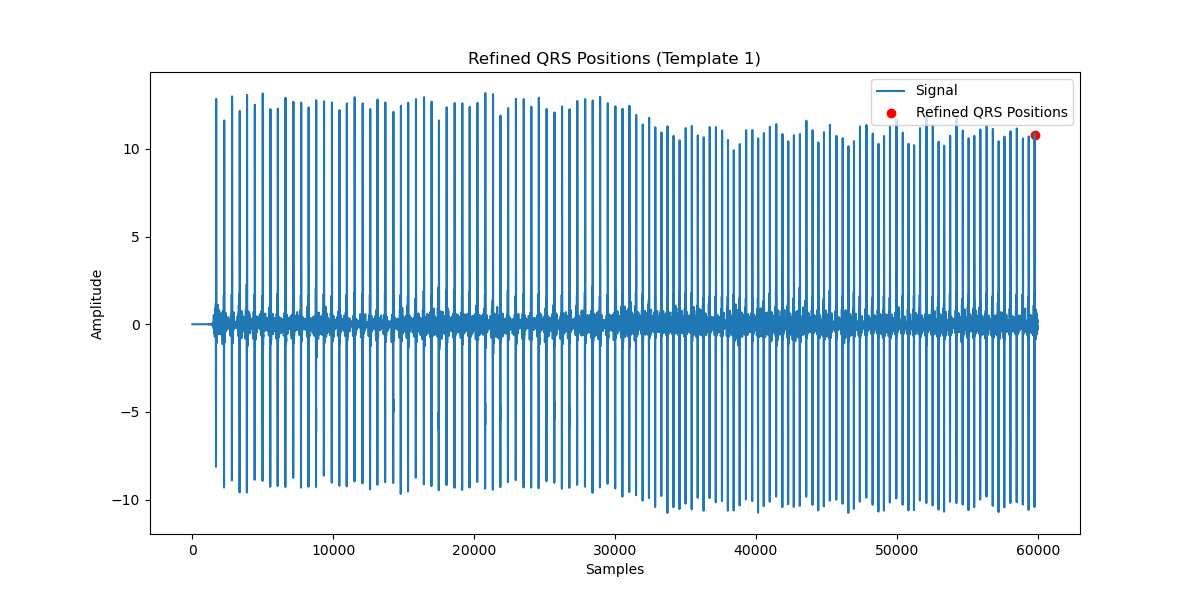

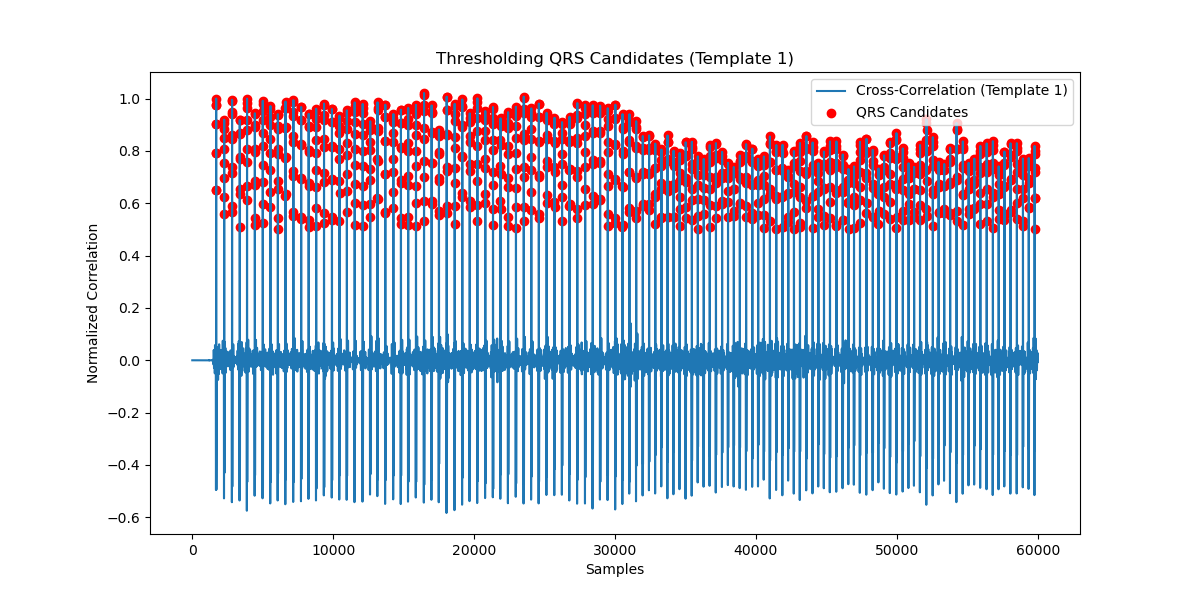

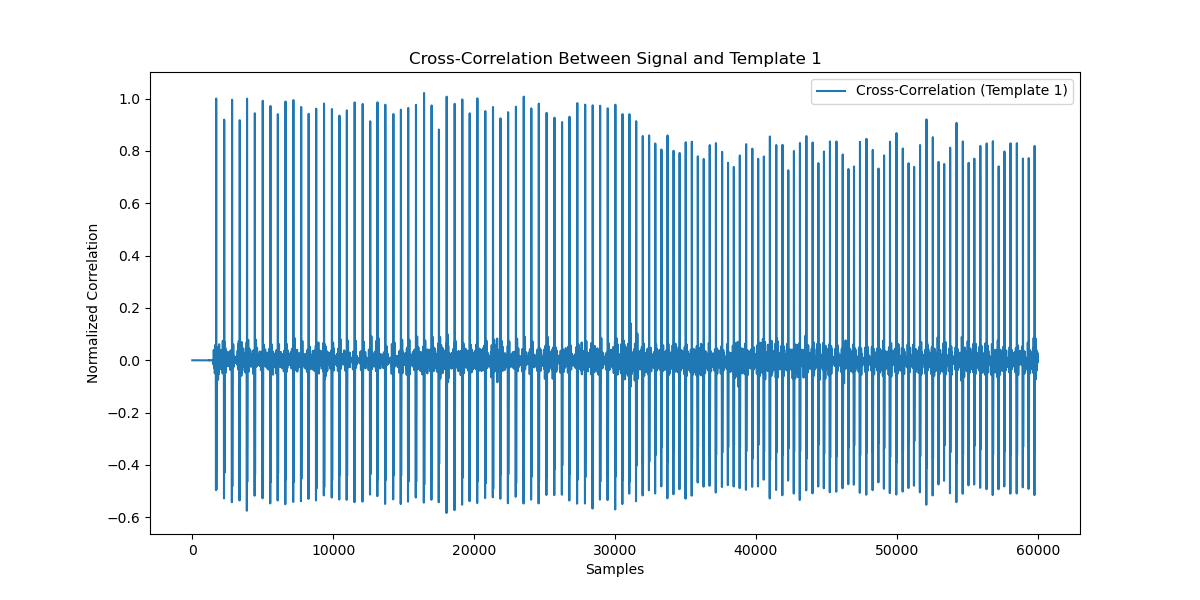

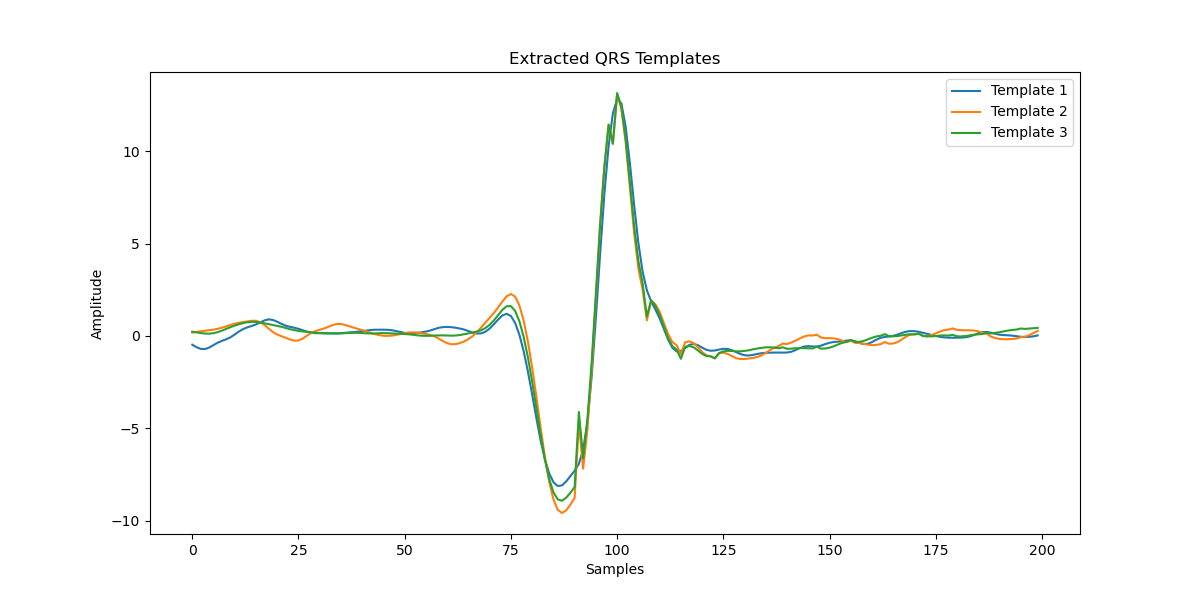

In [451]:
peaks = QRS_detector(s3,show_plot=True)